<a href="https://colab.research.google.com/github/zabihin/Block4-NLP_disaster_tweet/blob/main/2_Twitter_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load the data

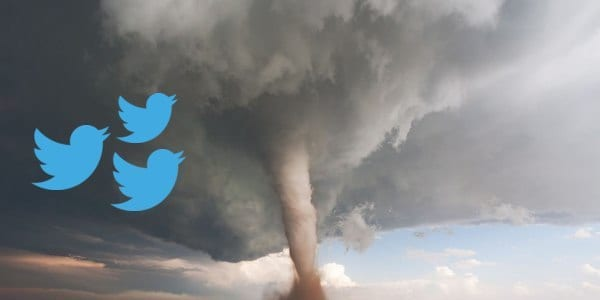

###Importing Libraries

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import ModelCheckpoint

from termcolor import colored

from sklearn.model_selection import train_test_split

In [ ]:
#load data
train_tweet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

test_tweet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

display (train_tweet.head())
print (train_tweet.shape)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 5)


##Data Cleaning

In [ ]:
train_tweet.drop(['id','keyword','location'],axis=1,inplace=True)




find that if the same twitt have differenet target?





In [ ]:
#find if there are same tweets with different targets
train_tweet['index_t'] = train_tweet.index # make list of originals index

aggs = {'target': 'mean',
         'index_t':lambda x: list(x)} # Keep track of the index 
grouped_df = train_tweet[train_tweet['text'].duplicated(keep=False)].groupby('text').agg(aggs) 

# if target mean is not equal to 0 or 1 --> we have same tweets with different targets
dif_targets = grouped_df[(grouped_df.target!=1) & (grouped_df.target!=0)].reset_index()
dif_targets

,text,target,index_t
0,#Allah describes piling up #wealth thinking it...,0.333333,"[4290, 4299, 4312]"
1,#foodscare #offers2go #NestleIndia slips into ...,0.666667,"[4221, 4239, 4244]"
2,.POTUS #StrategicPatience is a strategy for #G...,0.750000,"[2830, 2831, 2832, 2833]"
3,CLEARED:incident with injury:I-495 inner loop...,0.666667,"[4597, 4605, 4618]"
4,Caution: breathing may be hazardous to your he...,0.500000,"[4232, 4235]"
5,He came to a land which was engulfed in tribal...,0.333333,"[3240, 3243, 3248, 3251, 3261, 3266]"
6,Hellfire is surrounded by desires so be carefu...,0.333333,"[4285, 4305, 4313]"
7,Hellfire! We donÛªt even want to think about ...,0.500000,"[4306, 4320]"
8,I Pledge Allegiance To The P.O.P.E. And The Bu...,0.500000,"[1214, 1365]"
9,In #islam saving a person is equal in reward t...,0.500000,"[6614, 6616]"


so if the mean of target for same tweets is greater than 0.5 I change all of targets to 1, if the mean is less than 0.5 I change it to 0 and  i remove the tweets if the mean =0.5
then I remove repeated tweets and  do re index

In [ ]:
for ind in range(len(dif_targets.index)):
  if dif_targets.target[ind]>0.5:
    for l in dif_targets.index_t[ind]:
      train_tweet.target[l]=1
  elif dif_targets.target[ind]<0.5: 
    for l in dif_targets.index_t[ind]:
      train_tweet.target[l]=0
  else:
    train_tweet.drop(dif_targets.index_t[ind],inplace=True)
 

train_tweet.drop_duplicates(keep='first',inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
train_tweet.shape

(7589, 3)

#clean text

In [ ]:
# Function to clean the text
def clean_text(text):
    # remove punctuation
    text = ''.join([c for c in text if c not in r"[!\"#@$%&()'‰ûª*+,-./:;<=>?[\\\]^_`{|}~]+"]) 
    # remove stopwords
    text = ' '.join([c for c in text.split() if c not in STOP_WORDS])
    # remove numbers
    text = ''.join([c for c in text if not c.isdigit()])
    # lowercase
    text = ' '.join(text.split()).lower()
    # lemmatize
    text = ' '.join([c.lemma_ for c in nlp(text)])
    # remove words starting by http
    text = ' '.join([c for c in text.split() if not c.startswith("http")])
    
    return text

In [ ]:
train_tweet["text_clean"] = train_tweet["text"].apply(clean_text)


##Tokenization and Padding ckeaned text

In [ ]:
# Creation of a tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)

# Training the tokenizer on the training set
tokenizer.fit_on_texts(train_tweet['text_clean'])

# Transform the text into sequences of integers
train_tweet["text_encoded"] = tokenizer.texts_to_sequences(train_tweet["text_clean"])

In [ ]:
#preprosses test
test_tweet["text_clean"] = test_tweet["text"].apply(clean_text)

test_tweet["text_encoded"] = tokenizer.texts_to_sequences(test_tweet["text_clean"])


In [ ]:
# get the max length for padding
dataframes = [train_tweet,test_tweet]
max_pad = max([max(df['text_encoded'].apply(lambda x: len(x))) for df in dataframes])


In [ ]:
text_pad_train = tf.keras.preprocessing.sequence.pad_sequences(train_tweet["text_encoded"], padding="post", maxlen=max_pad)
text_pad_test = tf.keras.preprocessing.sequence.pad_sequences(test_tweet["text_encoded"], padding="post", maxlen=max_pad)


In [ ]:
train_tweet.reset_index(drop=True, inplace=True)
train_tweet.tail()

,text,target,index_t,text_clean,text_encoded
7584,Two giant cranes holding a bridge collapse int...,1,7608,two giant crane hold bridge collapse nearby home,"[289, 696, 1015, 382, 303, 55, 553, 39]"
7585,@aria_ahrary @TheTawniest The out of control w...,1,7609,ariaahrary thetawniest the control wild fire c...,"[5471, 5472, 2, 605, 270, 6, 51, 170, 232, 173..."
7586,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,7610,m utckm s volcano hawaii,"[7, 3472, 11, 469, 1331]"
7587,Police investigating after an e-bike collided ...,1,7611,police investigate ebike collided car little p...,"[34, 801, 2631, 2632, 58, 254, 4324, 2631, 161..."
7588,The Latest: More Homes Razed by Northern Calif...,1,7612,the late more home raze northern california wi...,"[2, 144, 111, 39, 425, 170, 51, 104, 525, 17]"


In [ ]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(text_pad_train, train_tweet["target"], test_size=0.3)

# Turns dataframe into tensors
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

vocab_size = tokenizer.num_words # the number of words in the vocabulary

#RNN

In [ ]:
max_pad

28

In [ ]:


# Define a text classifier model
model_RNN = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=8, input_shape=[max_pad,]),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification between 0 and 1
])

model_RNN.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint("model/RNN_analysis.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') 

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 28, 8)             80000     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
____________________________________________________

In [ ]:
# Trains the model
history = model_RNN.fit(
    np.array(X_train), #must convert to numpy array before sending to model
    np.array(y_train), #must convert to numpy array before sending to model
    epochs=15, 
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks = [checkpoint])

Epoch 1/15
65/83 [======================>.......] - ETA: 0s - loss: 0.6852 - accuracy: 0.5649
Epoch 1: val_accuracy improved from -inf to 0.57927, saving model to model/RNN_analysis.h5
83/83 [==============================] - 5s 6ms/step - loss: 0.6837 - accuracy: 0.5653 - val_loss: 0.6749 - val_accuracy: 0.5793
Epoch 2/15
65/83 [======================>.......] - ETA: 0s - loss: 0.6724 - accuracy: 0.5712
Epoch 2: val_accuracy did not improve from 0.57927
83/83 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.5676 - val_loss: 0.6607 - val_accuracy: 0.5793
Epoch 3/15
65/83 [======================>.......] - ETA: 0s - loss: 0.6454 - accuracy: 0.5969
Epoch 3: val_accuracy improved from 0.57927 to 0.67765, saving model to model/RNN_analysis.h5
83/83 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6037 - val_loss: 0.6251 - val_accuracy: 0.6776
Epoch 4/15
65/83 [======================>.......] - ETA: 0s - loss: 0.5933 - accuracy: 0.7221
E

In [ ]:
# Plot the accuracy and validation accuracy
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["accuracy"],
                          name="accuracy",
                          mode="lines",),
                      go.Scatter(
                          y=history.history["val_accuracy"],
                          name="val_accuracy",
                          mode="lines")
])

fig.update_layout(
    title='Accuracy and Validation Accuracy by Epoch',
    xaxis_title='epochs',
    yaxis_title='',
    yaxis=dict(range=[0, 1])

)
fig.show()

In [ ]:
# Prediction
test_tweet['model_preds'] = model_RNN.predict(text_pad_test)
test_tweet['target'] = test_tweet['model_preds'].apply(lambda x: 1 if x >= 0.5 else 0)
display(test_tweet.head())


,id,keyword,location,text,text_clean,text_encoded,model_preds,target
0,0,NaN,NaN,Just happened a terrible car crash,just happen terrible car crash,"[202, 217, 1628, 58, 24]",0.791096,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[153, 216, 1016, 178, 412, 1202]",0.712363,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street I save,"[157, 6, 592, 2862, 2185, 445, 1, 148]",0.952990,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[391, 3168, 5935, 104]",0.814450,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[457, 574, 21, 400, 1020]",0.974027,1


In [ ]:
# Create a submission file for Kaggle
submission = test_tweet[["id", "target"]]

# Save the submission file
submission.to_csv("submission_RNN.csv", index=False, header=True)

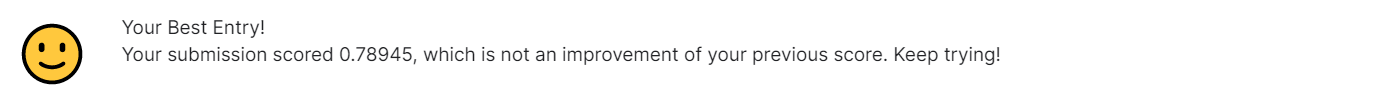

#LSTM


In [ ]:
# Defines a text classifier model
model_lstm = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=8, input_shape=[max_pad,]),
    LSTM(units=64, return_sequences=True),
    LSTM(units=32, return_sequences=False), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint("model/lstm.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') 

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 28, 8)             80000     
                                                                 
 lstm (LSTM)                 (None, 28, 64)            18688     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 111,649
Trainable params: 111,649
Non-tr

In [ ]:
# Trains the model
history_lstm = model_lstm.fit(
    np.array(X_train), #must convert to numpy array before sending to model
    np.array(y_train), #must convert to numpy array before sending to model
    epochs=15, 
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks = [checkpoint])

Epoch 1/15
77/83 [==========================>...] - ETA: 0s - loss: 0.6475 - accuracy: 0.6116
Epoch 1: val_accuracy improved from -inf to 0.78085, saving model to model/lstm.h5
83/83 [==============================] - 5s 16ms/step - loss: 0.6390 - accuracy: 0.6226 - val_loss: 0.4893 - val_accuracy: 0.7809
Epoch 2/15
81/83 [============================>.] - ETA: 0s - loss: 0.4065 - accuracy: 0.8362
Epoch 2: val_accuracy improved from 0.78085 to 0.79886, saving model to model/lstm.h5
83/83 [==============================] - 1s 7ms/step - loss: 0.4047 - accuracy: 0.8373 - val_loss: 0.4547 - val_accuracy: 0.7989
Epoch 3/15
81/83 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.9018
Epoch 3: val_accuracy did not improve from 0.79886
83/83 [==============================] - 1s 7ms/step - loss: 0.2697 - accuracy: 0.9021 - val_loss: 0.5726 - val_accuracy: 0.7664
Epoch 4/15
81/83 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9317
Epoch 4: val_acc

In [ ]:
# Plot the accuracy and validation accuracy
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_lstm.history["accuracy"],
                          name="accuracy",
                          mode="lines",),
                      go.Scatter(
                          y=history_lstm.history["val_accuracy"],
                          name="val_accuracy",
                          mode="lines")
])

fig.update_layout(
    title='Accuracy and Validation Accuracy by Epoch',
    xaxis_title='epochs',
    yaxis_title='',
    yaxis=dict(range=[0, 1])

)
fig.show()

In [ ]:
# Prediction
test_tweet['model_preds'] = model_lstm.predict(text_pad_test)
test_tweet['target'] = test_tweet['model_preds'].apply(lambda x: 1 if x >= 0.5 else 0)
display(test_tweet.head())


,id,keyword,location,text,text_clean,text_encoded,model_preds,target
0,0,NaN,NaN,Just happened a terrible car crash,just happen terrible car crash,"[202, 217, 1628, 58, 24]",0.996439,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[153, 216, 1016, 178, 412, 1202]",0.003025,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street I save,"[157, 6, 592, 2862, 2185, 445, 1, 148]",0.999963,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[391, 3168, 5935, 104]",0.300262,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[457, 574, 21, 400, 1020]",0.999963,1


In [ ]:
# Create a submission file for Kaggle
submission = test_tweet[["id", "target"]]

# Save the submission file
submission.to_csv("submission_LSTM.csv", index=False, header=True)

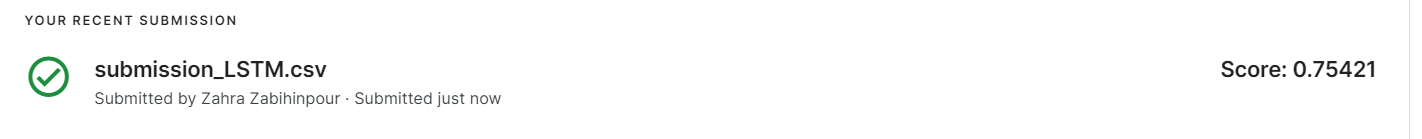

#GRU

In [ ]:
# Defines a text classifier model
model_gru = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=8, input_shape=[max_pad,]),
    GRU(units=64, return_sequences=True),
    GRU(units=32, return_sequences=False), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model_gru.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint("model/gru.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') 

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 28, 8)             80000     
                                                                 
 gru (GRU)                   (None, 28, 64)            14208     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 104,161
Trainable params: 104,161
Non-tr

In [ ]:
# Trains the model
history_gru= model_gru.fit(
    np.array(X_train), #must convert to numpy array before sending to model
    np.array(y_train), #must convert to numpy array before sending to model
    epochs=15, 
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks = [checkpoint])

Epoch 1/15
80/83 [===========================>..] - ETA: 0s - loss: 0.6867 - accuracy: 0.5631
Epoch 1: val_accuracy improved from -inf to 0.57927, saving model to model/gru.h5
83/83 [==============================] - 4s 18ms/step - loss: 0.6872 - accuracy: 0.5616 - val_loss: 0.6809 - val_accuracy: 0.5793
Epoch 2/15
76/83 [==========================>...] - ETA: 0s - loss: 0.6855 - accuracy: 0.5676
Epoch 2: val_accuracy did not improve from 0.57927
83/83 [==============================] - 1s 7ms/step - loss: 0.6854 - accuracy: 0.5676 - val_loss: 0.6806 - val_accuracy: 0.5793
Epoch 3/15
81/83 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6163
Epoch 3: val_accuracy improved from 0.57927 to 0.77866, saving model to model/gru.h5
83/83 [==============================] - 1s 7ms/step - loss: 0.6432 - accuracy: 0.6209 - val_loss: 0.4885 - val_accuracy: 0.7787
Epoch 4/15
81/83 [============================>.] - ETA: 0s - loss: 0.3958 - accuracy: 0.8412
Epoch 4: val_accur

In [ ]:
# Plot the accuracy and validation accuracy
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_gru.history["accuracy"],
                          name="accuracy",
                          mode="lines",),
                      go.Scatter(
                          y=history_gru.history["val_accuracy"],
                          name="val_accuracy",
                          mode="lines")
])

fig.update_layout(
    title='Accuracy and Validation Accuracy by Epoch',
    xaxis_title='epochs',
    yaxis_title='',
    yaxis=dict(range=[0, 1])

)
fig.show()

In [ ]:
# Prediction
test_tweet['model_preds'] = model_gru.predict(text_pad_test)
test_tweet['target'] = test_tweet['model_preds'].apply(lambda x: 1 if x >= 0.5 else 0)
display(test_tweet.head())


,id,keyword,location,text,text_clean,text_encoded,model_preds,target
0,0,NaN,NaN,Just happened a terrible car crash,just happen terrible car crash,"[202, 217, 1628, 58, 24]",0.983554,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[153, 216, 1016, 178, 412, 1202]",0.062544,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street I save,"[157, 6, 592, 2862, 2185, 445, 1, 148]",0.999407,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[391, 3168, 5935, 104]",0.587871,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[457, 574, 21, 400, 1020]",0.999453,1


In [ ]:
# Create a submission file for Kaggle
submission = test_tweet[["id", "target"]]

# Save the submission file
submission.to_csv("submission_GRU.csv", index=False, header=True)

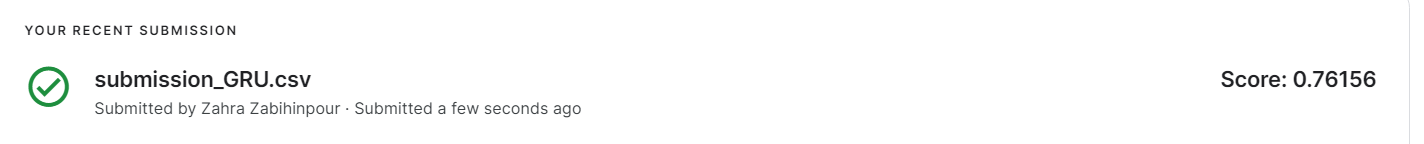